In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing as sk
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean_rate(dataframe):
    dataframe = re.sub('/5', '',str(dataframe)) #Replacing all ratings to a single value
    dataframe = re.sub('-', '0', str(dataframe)) #Replacing all values containing '-' with 0 rating since the number of votes are also 0
    dataframe = re.sub('NEW', '0', str(dataframe)) #Replacing all values containing 'NEW' with 0 rating since the number of votes are also 0 and the restaurant is new
    dataframe = re.sub('nan', '0', str(dataframe)) #Replacing all values containing 'nan' with 0 rating
    return float(dataframe)

In [3]:
def clean_approx_cost(dataframe):
     dataframe = re.sub(',','', str(dataframe))
     return int(dataframe)

In [4]:
def scale_to_zero_mean_and_unit_variance(column):
    scaled_data = np.array(sk.scale(column))
    scaled_data = np.reshape(scaled_data,(scaled_data.shape[0],1))
    return scaled_data

In [5]:
def one_hot_encoding_of_column(column):
    # First, use LabelEncoder to convert Strings to numeric values as OHE does not accept Strings
    lab_enc = sk.LabelEncoder()
    lab_enc.fit(column)
    label_encoded = lab_enc.transform(column)
    
    # Reshape the label_encoded array into a Nx1 matrix as OHE requires a 2-D matrix as input
    label_encoded = np.reshape(label_encoded, (label_encoded.shape[0],1))
    
    # Perform One-Hot-Encoding
    OHE_encoder = sk.OneHotEncoder(sparse=False)
    OHE_encoder.fit(label_encoded)
    OHE_result = OHE_encoder.transform(label_encoded)

    return OHE_result

In [6]:
def multi_label_binarize_column(column):
    mlb = MultiLabelBinarizer()
    mlb_binarized = mlb.fit_transform(column)
    return mlb_binarized

In [7]:
def preprocess_data(data):

    # Scale the rate column
    clean_data = scale_to_zero_mean_and_unit_variance(data[:,0])
    
    # One-hot-encode the location column
    location_column_clean = one_hot_encoding_of_column(data[:,1])
    clean_data = np.append(clean_data, location_column_clean, axis=1)
    
    # Encode rest-type column using multi label binarizer
    rest_type_column_clean = multi_label_binarize_column(data[:,2])
    clean_data = np.append(clean_data, rest_type_column_clean, axis=1)
    
    # Encode cuisines column using multi label binarizer
    cuisines_column_clean = multi_label_binarize_column(data[:,3])
    clean_data = np.append(clean_data, cuisines_column_clean, axis=1)   
    
    return clean_data

## 1. Introduction

a.

## 2. Data pre-processing

In [8]:
# Load the data
df = pd.read_csv('zomato.csv')

# Read test dataset from file and name the columns
# df_test = pd.read_csv('dataset1_test.csv', header=None)
# df_test.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]

# Drop rows from train and test which are Nan (i.e remove dirty data)
# df = df.dropna()
# df_test.dropna()
print(df.shape)
df = df.drop(columns=['url','phone','reviews_list','menu_item','listed_in(city)', 'votes', 'dish_liked'])
print(df.shape)
print(df.columns)
# fig, ax = plt.subplots()
# print(df['location'].value_counts().plot(ax=ax, kind='bar'))
# df['location'].value_counts().plot(ax=ax, kind='bar')


# sns.set(style="whitegrid")
# ax = sns.countplot(x="location", data=df)



(51717, 17)
(51717, 10)
Index(['address', 'name', 'online_order', 'book_table', 'rate', 'location',
       'rest_type', 'cuisines', 'approx_cost(for two people)',
       'listed_in(type)'],
      dtype='object')


In [9]:
df['rate'] = df['rate'].apply(clean_rate)
print(df.shape)
df.dropna(subset=['location', 'cuisines','rest_type','online_order','book_table','listed_in(type)','approx_cost(for two people)'], inplace=True)
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(clean_approx_cost)
df = df.drop_duplicates(subset=['name','address'], keep='first')

(51717, 10)


In [10]:
print(df.isna().sum())
print(df.shape)

address                        0
name                           0
online_order                   0
book_table                     0
rate                           0
location                       0
rest_type                      0
cuisines                       0
approx_cost(for two people)    0
listed_in(type)                0
dtype: int64
(12382, 10)


In [11]:
df_grouped_locations=df.groupby(['location'], as_index=False)['rate'].mean().max() # Get the location with the maximum rating
print(df_grouped_locations)
print(df.loc[df['location'] == 'Yeshwantpur'])

location    Yeshwantpur
rate            3.92941
dtype: object
                                                 address  \
39427  Hotel Krishinton, Opposite IISC D gate. M. S. ...   
39465  333, MSR Road, Gokul Extension, Mathikere, Yes...   
39490  6, 1st Cross Modal Colony, Yeshwantpur, Bangalore   
39491  40/7, Sri Sai Complex, MSRCE College Road, Mat...   
39502  40/7/A, Sri Sai Complex MSRCE College Road, Ma...   
39510           1st Cross, MSRE College Road, Mathikere,   
39533  2/1, 1st Cross, 14th Main, MSR Road, Mathikere...   
39541   369, 6th Main, 8th Cross, Yeshwantpur, Bangalore   
39543  45/1, Below Corporation Bank, Tumkur Road, RMC...   
39562  HMT Main Road ,Near HDFC Bank, Mathikere, Yesh...   
39566  26/1, Triveni Road, Mathikere Extension, Mathi...   
39574  3, YMS Complex, Opposite Ramaiah College, Math...   
39578  HMT Main Road, Near HDFC Bank, Mathikere, Yesh...   
39590  Level-2, Vaishnavi Sapphire Centre, Tumkur Roa...   
39594           2,1st Cross, MSR Colle

In [12]:
df_labels = df.drop(columns=['address','name','online_order','book_table','rate', 'location','rest_type','cuisines','listed_in(type)'])
df_data = df.drop(columns=['approx_cost(for two people)','address','online_order','book_table','listed_in(type)','name'])
df_data.to_csv('out_train.csv', encoding='utf-8', index=False)
data_raw = df_data.as_matrix()
labels_raw = df_labels.as_matrix()
data_raw

array([[4.1, 'Banashankari', 'Casual Dining',
        'North Indian, Mughlai, Chinese'],
       [4.1, 'Banashankari', 'Casual Dining',
        'Chinese, North Indian, Thai'],
       [3.8, 'Banashankari', 'Cafe, Casual Dining',
        'Cafe, Mexican, Italian'],
       ...,
       [3.3, 'KR Puram', 'Quick Bites', 'North Indian, Kerala, Chinese'],
       [2.5, 'Whitefield', 'Casual Dining, Bar',
        'Andhra, South Indian, Chinese, North Indian'],
       [0.0, 'Whitefield', 'Bar', 'Finger Food']], dtype=object)

In [13]:
data = preprocess_data(data_raw)

In [14]:
data.shape

(12382, 181)

In [15]:
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
scores = cross_val_score(clf, data, labels_raw, cv=8)
scores

array([0.46719785, 0.22427555, 0.10773347, 0.31303146, 0.27331554,
       0.21734909, 0.18838679, 0.25329548])

In [16]:
mlp_reg = MLPRegressor(activation='logistic')
scores = cross_val_score(mlp_reg, data, labels_raw, cv=8)
scores

array([0.60493996, 0.47735481, 0.37621057, 0.54512807, 0.52298868,
       0.46700712, 0.41331197, 0.4912198 ])

In [17]:
# Split the train data into train and validation 
X_train, X_validation, y_train, y_validation = train_test_split(data, labels_raw, test_size=0.20, random_state=42)
print(f"Dimensions of training data: {X_train.shape}")
print(f"Dimensions of validation data: {X_validation.shape}")

Dimensions of training data: (9905, 181)
Dimensions of validation data: (2477, 181)


In [18]:
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
train_scores = cross_val_score(clf, X_train, y_train, cv=8)
train_scores

array([0.21218243, 0.17919667, 0.22255235, 0.20012165, 0.25411509,
       0.25703078, 0.18684699, 0.2725887 ])

In [19]:
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
val_scores = cross_val_score(clf, X_validation, y_validation, cv=8)
val_scores

array([0.07509616, 0.11273006, 0.1701913 , 0.06585766, 0.10294073,
       0.05409279, 0.05238615, 0.09149799])

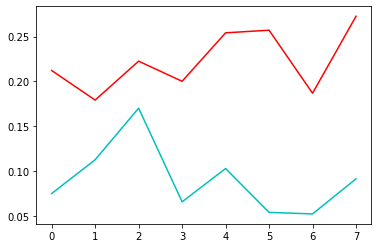

In [20]:
plt.plot(train_scores, 'r')
plt.plot(val_scores, 'c')
plt.show()